In [1]:
import os 

import pandas as pd
import s3fs
import mlflow

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url":'http://minio.minio:80',  # Minio 서버 주소
    },
    key='admin',                       # Minio access key
    secret='admin123',                    # Minio secret key
    use_ssl=False,                          # HTTP 사용시 False   
)

df = pd.read_csv('dataset/weather_data_recent_test.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Hour                      770 non-null    int64  
 1   Temperature(C)            770 non-null    float64
 2   Humidity(%)               770 non-null    int64  
 3   Wind speed (m/s)          770 non-null    float64
 4   Visibility (10m)          770 non-null    float64
 5   Dew point temperature(C)  770 non-null    float64
 6   Rainfall(mm)              770 non-null    float64
 7   Snowfall (cm)             770 non-null    float64
 8   Seasons                   770 non-null    int64  
 9   Holiday                   770 non-null    int64  
 10  hour diff                 770 non-null    float64
 11  Functioning Day           770 non-null    int64  
 12  rental_cnt                770 non-null    int64  
dtypes: float64(7), int64(6)
memory usage: 78.3 KB


In [3]:
HOST = "http://mlflow.mlflow:5000"
EXPREIMENT_NAME = "Manual Bike Rental Prediction"

os.environ['AWS_ACCESS_KEY_ID'] = 'admin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'admin123'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://minio.minio"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'admin1234567'

mlflow.set_tracking_uri(HOST)

registered_model_name = "Manual model"
version = 1

loaded_model = mlflow.xgboost.load_model(f"models:/{registered_model_name}/{version}")

In [4]:
X, y = df.drop('rental_cnt', axis=1), df["rental_cnt"]

In [5]:
# 데이터프레임 X의 컬럼 순서를 조정
X = X[loaded_model.feature_names_in_.tolist()]


y_predict = loaded_model.predict(X)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

mse = mean_squared_error(y, y_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_predict)
r2 = r2_score(y, y_predict)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')

MSE: 4028005.2768
RMSE: 2006.9891
MAE: 1394.4114
R2 Score: 0.5594


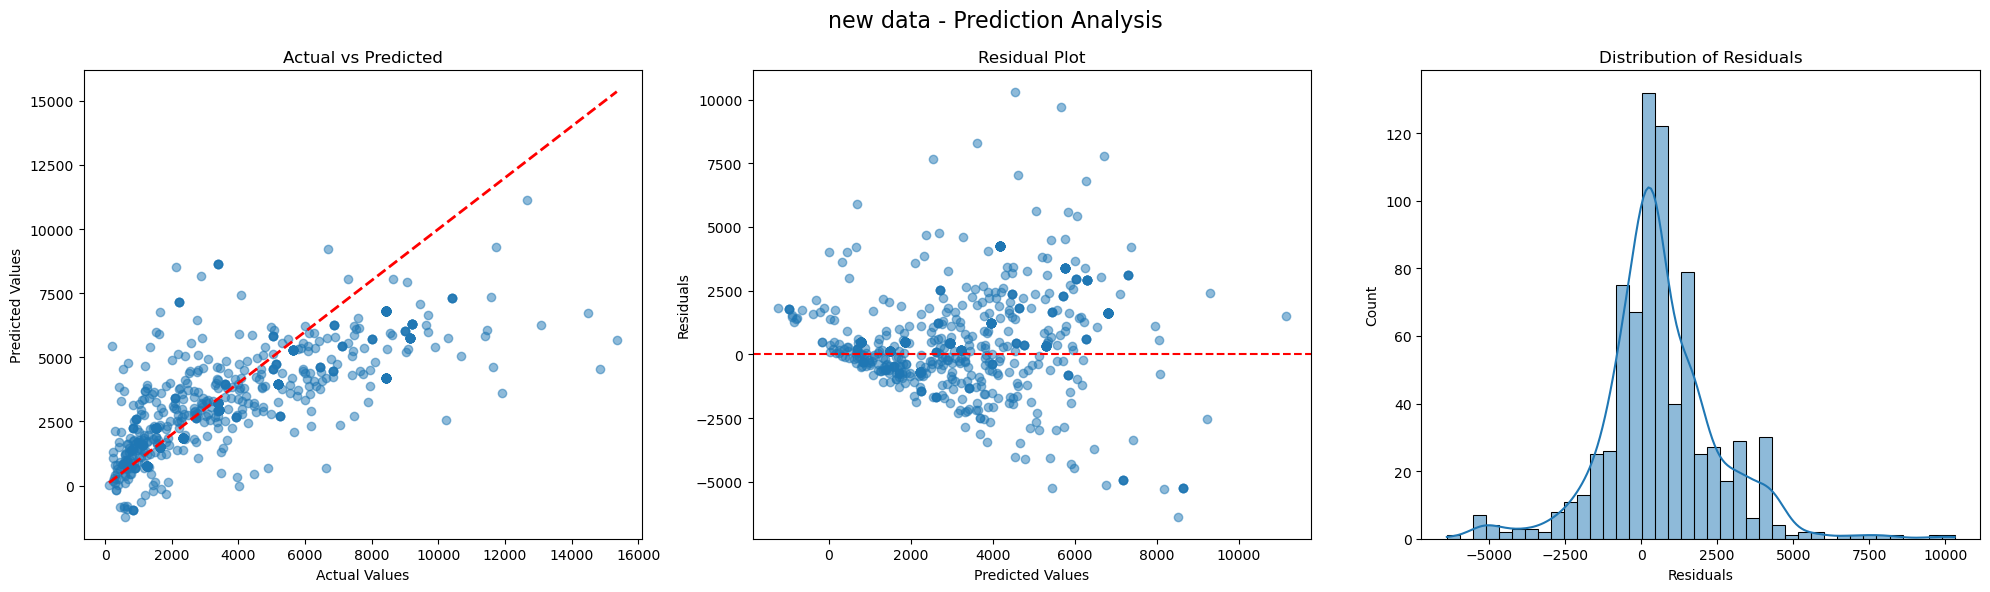

In [7]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 1. 산점도
ax1.scatter(y, y_predict, alpha=0.5)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('Actual vs Predicted')

# 3. 잔차 플롯
residuals = y - y_predict
ax2.scatter(y_predict, residuals, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')

sns.histplot(residuals, ax=ax3, kde=True)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Residuals')


plt.suptitle(f'new data - Prediction Analysis', fontsize=16)
plt.tight_layout()

# Jupyter Notebook에 표시
plt.show()

# 메모리 정리
plt.close()
